In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools
from collections import defaultdict

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial


from sklearn.manifold import TSNE

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
NUM_CORES = 14

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
classification_index_file = exports_location + "classification_index.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
classifications_index = pickle.load(open(classification_index_file))
#test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 43.8 s, sys: 2.24 s, total: 46.1 s
Wall time: 46.2 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [13]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [14]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    training_data = np.array(training_data)
    return training_data, training_labels

In [15]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

## Loading Specific Doc2vec Model

### Doc2vec and SVM Parameters

In [16]:
DOC2VEC_SIZE = 100
DOC2VEC_WINDOW = 5
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report vocab progress every x documents

In [17]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [18]:
best_epochs = {
    'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 14,
    'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 6,
    'doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 8
}

In [19]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

In [20]:
classifications = sections
classifications_type = 'sections'

In [21]:
epoch = 1
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
info("****************** Epoch {} --- Loading {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

info('Getting training Data')
X, y = get_training_data(doc2vec_model, classifications)

# info('Getting Validation Embeddings')
# Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
#                                                 validation_docs_list, validation_preprocessed_files_prefix,
#                                                 validation_preprocessed_docids_files_prefix)

2017-02-09 05:11:09,139 : INFO : ****************** Epoch 1 --- Loading doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-02-09 05:11:09,141 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-02-09 05:11:20,035 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-02-09 05:11:20,036 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-02-09 05:11:24,499 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models_

### Create Sample

In [44]:
NUM_PER_CLASS = 3000

In [45]:
%%time
section_docs = defaultdict(list)
i = 0
for tr_id in training_docs_list:
    doc_sections = [section for section in doc_classification_map[tr_id] if len(section) == 1]
    # choose this document if it's only assigned to one section
    if len(doc_sections) == 1:
        section_docs[doc_sections[0]].append(i)
    if i % 100000 == 0:
        info(i)
    i += 1

2017-02-09 05:50:16,571 : INFO : 0
2017-02-09 05:50:17,093 : INFO : 100000
2017-02-09 05:50:17,579 : INFO : 200000
2017-02-09 05:50:18,041 : INFO : 300000
2017-02-09 05:50:18,466 : INFO : 400000
2017-02-09 05:50:18,897 : INFO : 500000
2017-02-09 05:50:19,318 : INFO : 600000
2017-02-09 05:50:19,730 : INFO : 700000
2017-02-09 05:50:20,088 : INFO : 800000
2017-02-09 05:50:20,499 : INFO : 900000
2017-02-09 05:50:20,854 : INFO : 1000000
2017-02-09 05:50:21,258 : INFO : 1100000
2017-02-09 05:50:21,668 : INFO : 1200000


CPU times: user 5.07 s, sys: 1.37 s, total: 6.44 s
Wall time: 5.5 s


In [46]:
for section in sorted(section_docs):
    print '{}->{}, {}'.format(section, len(section_docs[section]), section_docs[section][:10])

A->130341, [43, 44, 48, 49, 59, 75, 77, 78, 83, 95]
B->133374, [11, 25, 28, 29, 30, 38, 39, 57, 61, 64]
C->67569, [19, 20, 21, 22, 24, 31, 32, 62, 73, 74]
D->4955, [325, 333, 348, 1133, 1350, 2644, 2645, 2895, 2901, 2957]
E->23172, [40, 547, 877, 893, 1006, 1024, 1036, 1247, 1249, 1255]
F->65536, [60, 121, 211, 331, 334, 338, 342, 345, 351, 353]
G->374353, [1, 2, 3, 4, 8, 9, 10, 12, 14, 15]
H->311307, [0, 5, 7, 13, 17, 36, 47, 50, 51, 53]


In [47]:
sample_indices = []
for section in sorted(section_docs):
    section_sample_indices = random.sample(section_docs[section], NUM_PER_CLASS)
    sample_indices.extend(section_sample_indices)
print len(sample_indices)

24000


In [48]:
X_sample = X[sample_indices]
y_sample = y[sample_indices]
print X_sample.shape
print y_sample.shape

(24000, 100)
(24000, 8)


In [49]:
y_sample_one = []
for y_row in y_sample[:]:
    nonzero = y_row.nonzero()[0]
    index = nonzero[0]
    y_sample_one.append(index)
y_sample_one = np.array(y_sample_one)

## Actual T-SNE Visualization

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for sample 13000 / 16000
[t-SNE] Computed conditional probabilities 

<IPython.core.display.Javascript object>


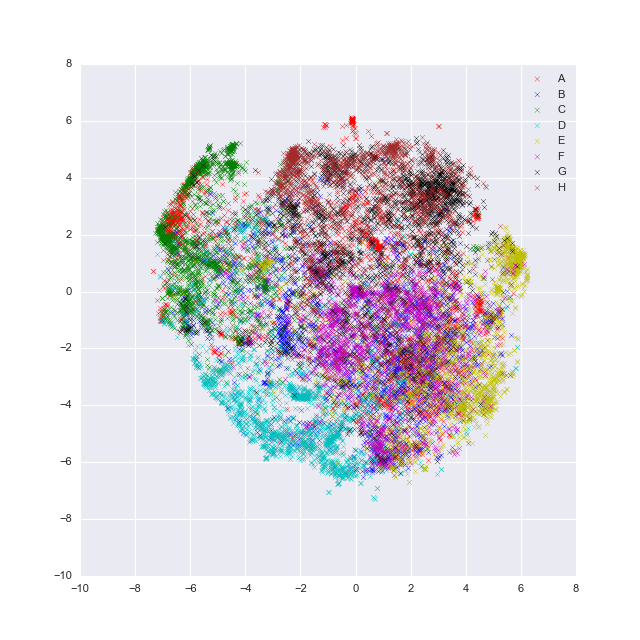

<IPython.core.display.Javascript object>


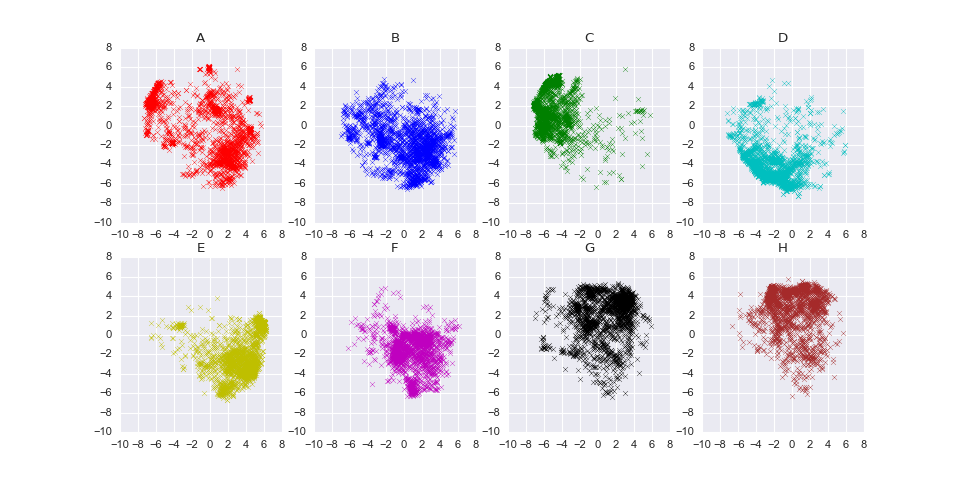

CPU times: user 6min 23s, sys: 58.2 s, total: 7min 22s
Wall time: 7min 4s


In [43]:
%%time
%matplotlib notebook
perp = 30
lr = 1000
n_iter = 1000
init_setting = 'pca'
method='barnes_hut'
n_iter_without_prog = 100
lrs = [100,300,500,1000]
# perps = [30,40,50,100,200]
n_iters = [1000,2000,3000]
# for lr in lrs:
for i in range(1):
# for n_iter in n_iters:
# for perp in perps:
    tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, method=method,
              verbose=3, init=init_setting, n_iter=n_iter, n_iter_without_progress=n_iter_without_prog)
    %time X_sample_tsne = tt.fit_transform(X_sample)
    fig2 = plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(14, 7))
    #fig2.suptitle('Perplexity: ' + str(perp))
#     ax = fig.add_subplot(331)
    big_ax = fig2.add_subplot(111)
    axes = []
    for i in range(len(sections)):
        axes.append(fig.add_subplot(int('24' + str(i+1))))
    scatters = []
    colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
    for i in range(len(sections)):
#         if sections[i] not in ['A', 'B']: continue
        sc = big_ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        scatters.append(sc)
        axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        axes[i].set_title(sections[i])
        time.sleep(0.2)
        fig.canvas.draw()
        fig2.canvas.draw()
#         if i > 4:
#             break
#     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
    big_ax.legend(scatters, sections, scatterpoints=1)
    for i in range(len(sections)):
        axes[i].axis(big_ax.axis())
    fig.canvas.draw()
    fig2.canvas.draw()

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sample 13000 / 24000
[t-SNE] Computed conditional probabilities 

<IPython.core.display.Javascript object>


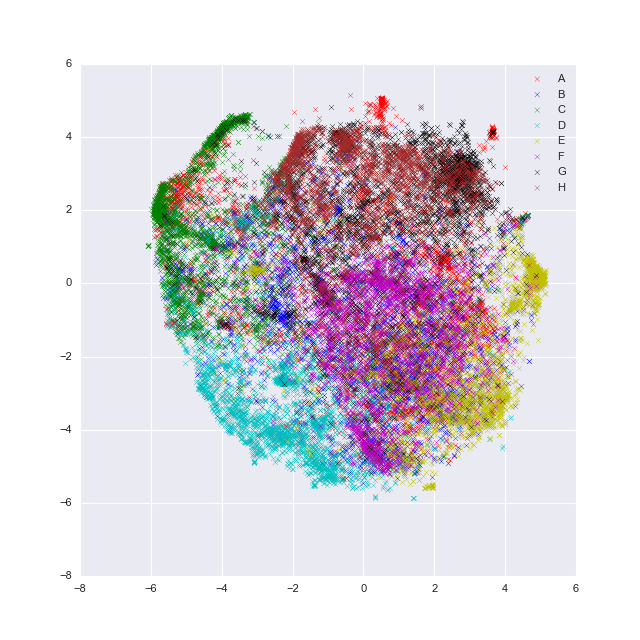

<IPython.core.display.Javascript object>


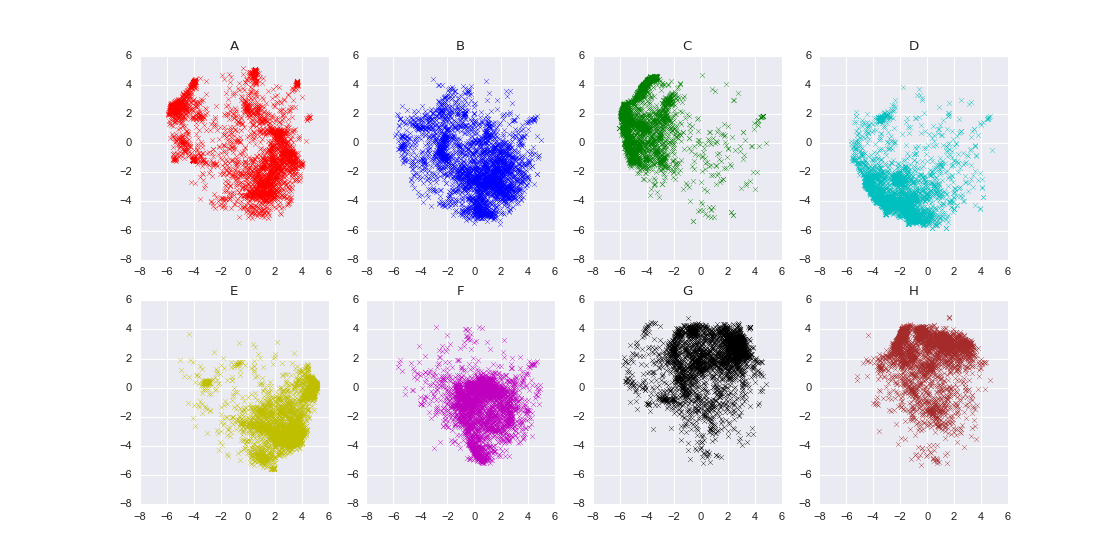

CPU times: user 12min 31s, sys: 1min 44s, total: 14min 15s
Wall time: 13min 45s


In [50]:
%%time
%matplotlib notebook
perp = 30
lr = 1000
n_iter = 1000
init_setting = 'pca'
method='barnes_hut'
n_iter_without_prog = 100
lrs = [100,300,500,1000]
# perps = [30,40,50,100,200]
n_iters = [1000,2000,3000]
# for lr in lrs:
for i in range(1):
# for n_iter in n_iters:
# for perp in perps:
    tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, method=method,
              verbose=3, init=init_setting, n_iter=n_iter, n_iter_without_progress=n_iter_without_prog)
    %time X_sample_tsne = tt.fit_transform(X_sample)
    fig2 = plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(14, 7))
    #fig2.suptitle('Perplexity: ' + str(perp))
#     ax = fig.add_subplot(331)
    big_ax = fig2.add_subplot(111)
    axes = []
    for i in range(len(sections)):
        axes.append(fig.add_subplot(int('24' + str(i+1))))
    scatters = []
    colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
    for i in range(len(sections)):
#         if sections[i] not in ['A', 'B']: continue
        sc = big_ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        scatters.append(sc)
        axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        axes[i].set_title(sections[i])
        time.sleep(0.2)
        fig.canvas.draw()
        fig2.canvas.draw()
#         if i > 4:
#             break
#     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
    big_ax.legend(scatters, sections, scatterpoints=1)
    for i in range(len(sections)):
        axes[i].axis(big_ax.axis())
    fig.canvas.draw()
    fig2.canvas.draw()

In [32]:
import seaborn

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.797163
[t-SNE] Iteration 25: error = 0.7794306, gradient norm = 0.0030627
[t-SNE] Iterat

<IPython.core.display.Javascript object>


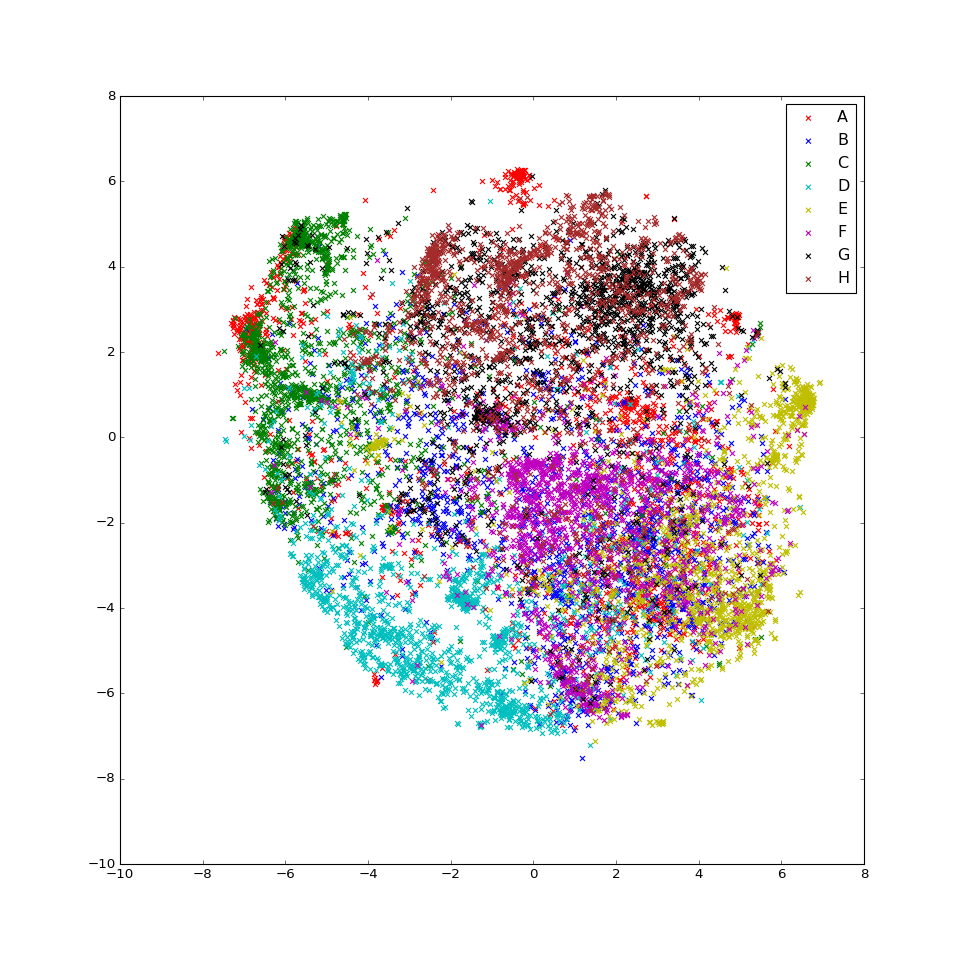

<IPython.core.display.Javascript object>


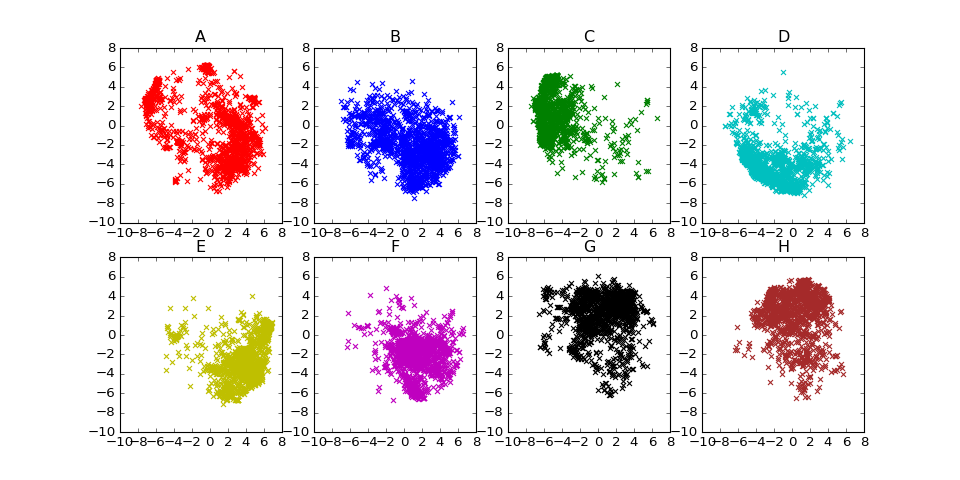

CPU times: user 4min 53s, sys: 39.7 s, total: 5min 33s
Wall time: 5min 21s


In [29]:
%%time
%matplotlib notebook
perp = 50
lr = 1000
n_iter = 1000
init_setting = 'pca'
method='barnes_hut'
n_iter_without_prog = 100
lrs = [100,300,500,1000]
# perps = [30,40,50,100,200]
n_iters = [1000,2000,3000]
# for lr in lrs:
for i in range(1):
# for n_iter in n_iters:
# for perp in perps:
    tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, method=method,
              verbose=3, init=init_setting, n_iter=n_iter, n_iter_without_progress=n_iter_without_prog)
    %time X_sample_tsne = tt.fit_transform(X_sample)
    fig2 = plt.figure(figsize=(12, 12))
    fig = plt.figure(figsize=(12, 6))
    #fig2.suptitle('Perplexity: ' + str(perp))
#     ax = fig.add_subplot(331)
    big_ax = fig2.add_subplot(111)
    axes = []
    for i in range(len(sections)):
        axes.append(fig.add_subplot(int('24' + str(i+1))))
    scatters = []
    colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
    for i in range(len(sections)):
#         if sections[i] not in ['A', 'B']: continue
        sc = big_ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        scatters.append(sc)
        axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        axes[i].set_title(sections[i])
        time.sleep(0.2)
        fig.canvas.draw()
        fig2.canvas.draw()
#         if i > 4:
#             break
#     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
    big_ax.legend(scatters, sections, scatterpoints=1)
    for i in range(len(sections)):
        axes[i].axis(big_ax.axis())
    fig.canvas.draw()
    fig2.canvas.draw()

<IPython.core.display.Javascript object>


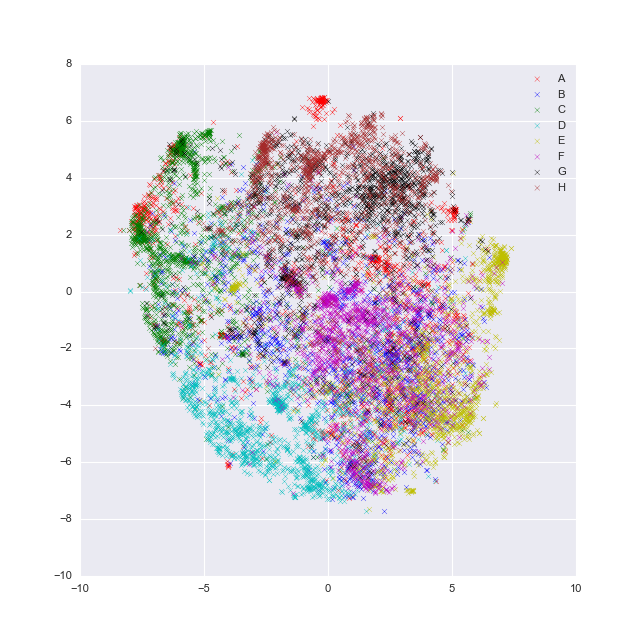

<IPython.core.display.Javascript object>


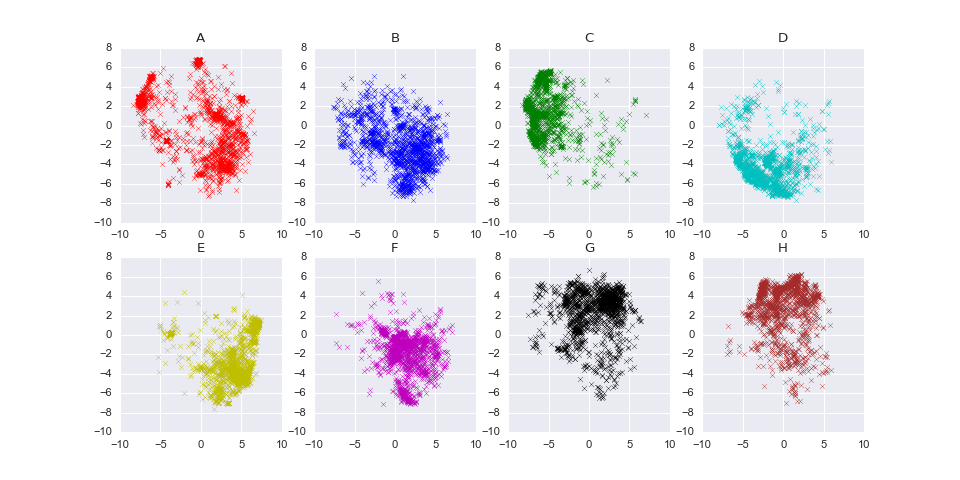

In [36]:
fig2 = plt.figure(figsize=(8, 8))
fig = plt.figure(figsize=(12, 6))
#fig2.suptitle('Perplexity: ' + str(perp))
#     ax = fig.add_subplot(331)
big_ax = fig2.add_subplot(111)
axes = []
for i in range(len(sections)):
    axes.append(fig.add_subplot(int('24' + str(i+1))))
scatters = []
colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
for i in range(len(sections)):
#         if sections[i] not in ['A', 'B']: continue
    sc = big_ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                color=colours[i],
                marker="x", label=sections[i])
    scatters.append(sc)
    axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                color=colours[i],
                marker="x", label=sections[i])
    axes[i].set_title(sections[i])
    time.sleep(0.2)
    fig.canvas.draw()
    fig2.canvas.draw()
#         if i > 4:
#             break
#     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
big_ax.legend(scatters, sections, scatterpoints=1)
for i in range(len(sections)):
    axes[i].axis(big_ax.axis())
fig.canvas.draw()
fig2.canvas.draw()

## Multiple T-SNE

In [41]:
doc2vec_methods_dict = {
    'doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None' : 7,
    'doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None' : 8,
    'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 14,
    'doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 1,
    'doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 6,
    'doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 7,
    'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 7,
    'doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 10,
    'doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 4,
    'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 18,
    'doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 9,
#     'doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 6,
#     'doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 5
}

In [ ]:
%%time
%matplotlib notebook
for (doc2vec_method_name, epoch) in doc2vec_methods_dict.items():
    print '********* {}->{}'.format(doc2vec_method_name, epoch)

    placeholder_model_name = doc2vec_method_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = doc2vec_method_name
    
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    

    info("****************** Epoch {} --- Loading {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        info("Couldnt find the doc2vec model with epoch {}".format(epoch))
        raise Exception()

    info('Getting training Data')
    X, y = get_training_data(doc2vec_model, classifications)

    # info('Getting Validation Embeddings')
    # Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
    #                                                 validation_docs_list, validation_preprocessed_files_prefix,
    #                                                 validation_preprocessed_docids_files_prefix)

    NUM_PER_CLASS = 2000

    %%time
    section_docs = defaultdict(list)
    i = 0
    for tr_id in training_docs_list:
        doc_sections = [section for section in doc_classification_map[tr_id] if len(section) == 1]
        # choose this document if it's only assigned to one section
        if len(doc_sections) == 1:
            section_docs[doc_sections[0]].append(i)
        if i % 100000 == 0:
            info(i)
        i += 1

    sample_indices = []
    for section in sorted(section_docs):
        section_sample_indices = random.sample(section_docs[section], NUM_PER_CLASS)
        sample_indices.extend(section_sample_indices)
    print len(sample_indices)


    X_sample = X[sample_indices]
    y_sample = y[sample_indices]
#     print X_sample.shape
#     print y_sample.shape

    y_sample_one = []
    for y_row in y_sample[:]:
        nonzero = y_row.nonzero()[0]
        index = nonzero[0]
        y_sample_one.append(index)
    y_sample_one = np.array(y_sample_one)


    perp = 50
    lr = 1000
    n_iter = 1000
    init_setting = 'pca'
    method='barnes_hut'
    n_iter_without_prog = 100
    lrs = [100,300,500,1000]
    perps = [20,30,40,50,100,200]
    n_iters = [1000,2000,3000]
    # for lr in lrs:
    # for i in range(1):
    # for n_iter in n_iters:
    for perp in perps:
        tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, method=method,
                  verbose=3, init=init_setting, n_iter=n_iter, n_iter_without_progress=n_iter_without_prog)
        %time X_sample_tsne = tt.fit_transform(X_sample)
        fig2 = plt.figure(figsize=(12, 12))
        fig = plt.figure(figsize=(12, 24))
        fig2.suptitle('Perplexity: ' + str(perp))
    #     ax = fig.add_subplot(331)
        big_ax = fig2.add_subplot(111)
        axes = []
        for i in range(len(sections)):
            axes.append(fig.add_subplot(int('42' + str(i+1))))
        scatters = []
        colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
        for i in range(len(sections)):
    #         if sections[i] not in ['A', 'B']: continue
            sc = big_ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                        y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                        color=colours[i],
                        marker="x", label=sections[i])
            scatters.append(sc)
            axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                        y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                        color=colours[i],
                        marker="x", label=sections[i])
            axes[i].set_title(sections[i])
            time.sleep(0.2)
            fig.canvas.draw()
            fig2.canvas.draw()
    #         if i > 4:
    #             break
    #     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
        big_ax.legend(scatters, sections, scatterpoints=1)
        for i in range(len(sections)):
            axes[i].axis(big_ax.axis())
        fig.canvas.draw()
        fig2.canvas.draw()

In [ ]:
%%time
%matplotlib notebook
perp = 100
lr = 1000
n_iter = 1000
init_setting = 'pca'
method='barnes_hut'
n_iter_without_prog = 100
lrs = [100,300,500,1000]
perps = [2,5,10,20,30,40,50,100,200]
n_iters = [1000,2000,3000]
# for lr in lrs:
for i in range(1):
# for n_iter in n_iters:
# for perp in perps:
    tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, method=method,
              verbose=3, init=init_setting, n_iter=n_iter, n_iter_without_progress=n_iter_without_prog)
    %time X_sample_tsne = tt.fit_transform(X_sample)
    fig = plt.figure(figsize=(12, 12))
    fig2 = plt.figue(figsize=(12, 7))
    plt.title(str(perp))
    fig.suptitle(str(perp))
    ax = fig.add_subplot(331)
    big_ax = fig2.add_subplot(111)
    axes = []
    for i in range(len(sections)):
        axes.append(fig.add_subplot(int('33' + str(i+2))))
    scatters = []
    colours = ['r', 'b', 'g', 'c', 'y', 'm', 'k', 'brown']
    for i in range(len(sections)):
#         if sections[i] not in ['A', 'B']: continue
        sc = ax.scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        scatters.append(sc)
        axes[i].scatter(x=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 0], 
                    y=X_sample_tsne[i*NUM_PER_CLASS:(i+1)*NUM_PER_CLASS, 1],
                    color=colours[i],
                    marker="x", label=sections[i])
        axes[i].set_title(sections[i])
        time.sleep(0.2)
        fig.canvas.draw()
#         if i > 4:
#             break
#     plt.scatter(X_sample_tsne[:, 0], X_sample_tsne[:, 1], c=y_sample_one, marker="x", )
    ax.legend(scatters, sections, scatterpoints=1)
    for i in range(len(sections)):
        axes[i].axis(ax.axis())
    fig.canvas.draw()

In [236]:
section = 'B'
section_index = sections.index(section)
for i in range(section_index*NUM_PER_CLASS, (section_index+1)* NUM_PER_CLASS):
    doc_id = training_docs_list[sample_indices[i]]
    print '{}->{}'.format(doc_id, set(doc_classification_map[doc_id]) & set(classes) )

08007119->set([u'B-60'])
08732894->set([u'B-08'])
07021612->set([u'B-60'])
07794638->set([u'B-29'])
08640900->set([u'B-65'])
07967159->set([u'B-65'])
07987959->set([u'B-60'])
07178623->set([u'B-60'])
07264536->set([u'B-24'])
08328313->set([u'B-41'])
08657482->set([u'B-01'])
07735822->set([u'B-65'])
07697020->set([u'B-41'])
08123201->set([u'B-01'])
08567876->set([u'B-62'])
07905388->set([u'B-65'])
08747600->set([u'B-27', u'B-29'])
07478822->set([u'B-62'])
07573373->set([u'B-60'])
08016357->set([u'B-60'])
07992365->set([u'B-67'])
07226570->set([u'B-01'])
08066343->set([u'B-41'])
07866634->set([u'B-66'])
07318858->set([u'B-03'])
08224513->set([u'B-60'])
08057621->set([u'B-31'])
07762483->set([u'B-02'])
07731784->set([u'B-01'])
07648149->set([u'B-60'])
08893670->set([u'B-25'])
08601897->set([u'B-25'])
08262079->set([u'B-65'])
07963242->set([u'B-63'])
08827545->set([u'B-01'])
08016950->set([u'B-08'])
08915277->set([u'B-60'])
08088201->set([u'B-01'])
07264238->set([u'B-65'])
08252406->set([u

## 3D Test

In [75]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
tt = TSNE(n_components=2, perplexity=perp, learning_rate=lr, 
              verbose=2, init=init_setting, n_iter=n_iter )
%time X_sample_tsne = tt.fit_transform(X_sample)

<IPython.core.display.Javascript object>


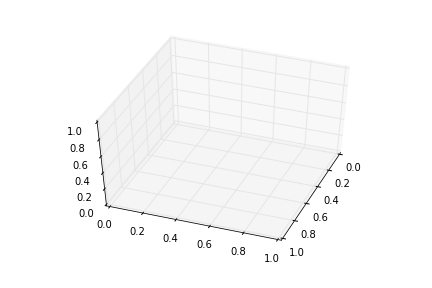

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

## Get Data as CSV

In [158]:
for x_row in X_sample_tsne:
    print '{},{}'.format(x_row[0], x_row[1])

15.0973212219,2.85349296259
2.2028353873,5.57109857349
5.52304266541,10.0055963951
0.642675216948,4.67205902996
9.9581373318,-6.9298345232
-7.37792797828,13.9959727053
-7.83840154745,12.8829478867
5.95643221473,7.71161169739
-8.81814483616,0.459812146517
9.66400403,1.69715680642
10.7320239669,-5.30147797938
11.4913999952,5.10828455157
-3.18221813445,6.74985639067
-3.67729582748,6.60755793541
-10.4505777589,3.54315397595
11.0978841375,-4.42826262946
-4.67009819528,7.77619009934
12.7975455984,7.26045384418
11.5735807312,-6.06239929187
-3.20214943524,5.0177240304
-4.94699272559,6.39931037694
11.4521628313,-5.63731589161
2.2138990681,5.89196695012
2.16025559084,5.61090459005
9.71876443929,-7.31555931157
13.5859094233,-3.36142516966
4.93415187382,9.22902852072
-10.2683630516,4.49735269298
-7.9496686455,13.0688101436
8.84123681194,9.66511450083
-2.11425645471,12.9743882885
-2.74974866322,0.998422643299
-2.40027172838,12.6341922394
9.43355306895,1.76868656889
3.72884969708,-8.62969994318
-0.6

In [159]:
for y_label_index in y_sample_one:
    print sections[y_label_index]

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


# PCA

In [38]:
from sklearn.decomposition import PCA

In [160]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

In [161]:
print pca.explained_variance_ratio_

[ 0.07329471  0.05664867]


In [162]:
X_pca

array([[-0.0598917 ,  0.43026024],
       [ 0.03388019, -1.52374641],
       [-0.91250477, -1.48319956],
       ..., 
       [ 1.00996944, -1.26204284],
       [-1.01508629,  1.04331252],
       [-1.21953394, -0.45678459]])

<IPython.core.display.Javascript object>


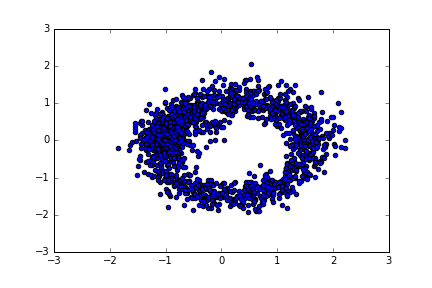

In [163]:
fig = plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1])

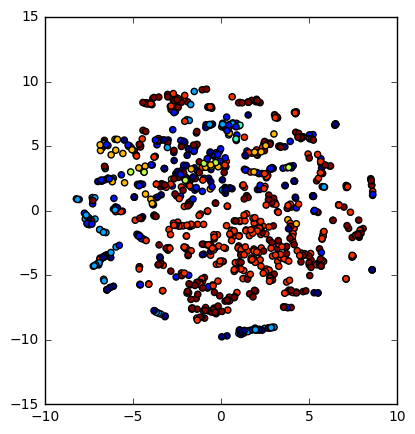

In [51]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(XV_tsne[:, 0], XV_tsne[:, 1], c=yv_one[:1000])